In [1]:
import awkward as ak
import numba
import numpy as np
import pandas as pd
import awkward as ak
import vector
vector.register_numba()
vector.register_awkward()
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

from importlib import reload

import numba
import spanet_predictions

In [1]:
pwd

'/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/SPANET'

In [2]:
@numba.njit
def assign_provenance_and_prob(t1pred, t2pred, hpred, 
                      t1prob, t2prob, hprob, njets):
    out = np.zeros((t1pred.shape[0], njets)) -1
    prob = np.zeros((t1pred.shape[0], njets, 3), dtype=np.float32)-np.float32(np.inf)
    
    #print(prob)
    for iev, (t1, t2, h, t1p, t2p, hp) in enumerate(zip(t1pred, t2pred, hpred, t1prob, t2prob, hprob)):
    
        if t1[0] == -2:
            prob_t1 = -np.inf
        else:
            prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
            
        if t2[0] == -2:
            prob_t2 = -np.inf
        else:
            prob_t2 = t2p[t2[0]]
            
        if h[0] == -2:
            prob_h = -np.inf
        else:
            prob_h = hp[h[0]][h[1]]
            
        
        # prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
        # prob_t2 = t2p[t2[0]][t2[1]]
        # prob_h = hp[h[0]][h[1]]
        # print(prob_t1, prob_t2, prob_h)
        
        for i in t1: 
            out[iev][i] = 1
            prob[iev][i][0] = prob_t1
        for i in t2: 
            out[iev][i] = 2
            prob[iev][i][1] = prob_t2
        for i in h: 
            out[iev][i] = 3
            prob[iev][i][2] = prob_h

    return out, prob

# Load directly the model

In [3]:
from spanet import evaluation

In [10]:
log_directory = "/work/dvalsecc/ttHbb/SPANet/SPANET_models/latest_Yuliia_model"

In [14]:
!ls /eos/user/d/dvalsecc/www/ttHbbAnalysis/SPANET_models

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.utf-8)
checkpoints
event.yaml
events.out.tfevents.1689340839.ymaidann-13424813.0-b7g57n1508.cern.ch.7.0
hparams.yaml
hparams.yaml~
index.php
options.json
options.json~
spanet-gpu.onnx
spanet-gpu2.onnx
spanet-gpu3.onnx
spanet.onnx
test_lep_met_ht.h5
train_lep_met_ht.h5


In [21]:
model = evaluation.load_model(log_directory)

Loading: /work/dvalsecc/ttHbb/SPANet/SPANET_models/latest_Yuliia_model/checkpoints/epoch=31-step=31808.ckpt

Now in base.init...

Index Range: 0...1018173
Index Range: 1018174...1131303
['t1', 't2', 'h'] {'t1': 'q1', 't2': 'b', 'h': 'b1'}

Now in validation.__init__...


In [22]:
model

JetReconstructionModel(
  (embedding): MultiInputVectorEmbedding(
    (vector_embedding_layers): ModuleList(
      (0): CombinedVectorEmbedding(
        (vector_embeddings): SequentialVectorEmbedding(
          (embedding_stack): EmbeddingStack(
            (embedding_layers): ModuleList(
              (0): GRUBlock(
                (normalization): LayerNorm(
                  (normalization): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
                )
                (linear_1): Sequential(
                  (0): Linear(in_features=4, out_features=8, bias=True)
                  (1): GELU(approximate='none')
                  (2): Dropout(p=0.2, inplace=False)
                )
                (linear_2): Sequential(
                  (0): Linear(in_features=8, out_features=16, bias=True)
                  (1): GELU(approximate='none')
                  (2): Dropout(p=0.2, inplace=False)
                )
                (gru): GRUGate(
                  (linear_W_r): Linea

# Use the onnx export

In [3]:
#basedir= "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_30_08_2023_v2/out_forTraining_sig_bkg"
basedir= "/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/"

In [4]:
os.listdir(basedir)

['_common_metadata',
 '_metadata',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PostVFP_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2017_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2018_v3.parquet',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov.parquet',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_labframe_part1.parquet',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_labframe_part2.parquet',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1.parquet',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation',
 'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetpr

In [5]:
df = ak.from_parquet(basedir)

In [6]:
df.fields

['jets',
 'partons_matched',
 'partons',
 'generator_info',
 'lepton_partons',
 'lepton_reco',
 'met',
 'higgs',
 'weight']

In [7]:
(jets,_,_,_,_,lep, met,_, weight) = ak.unzip(df)
jets = ak.with_name(jets, name="Momentum4D")
lep = ak.with_name(lep, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [8]:
jets

<MomentumArray4D [[{pt: 108, eta: 0.826, ... prov: -1}]] type='3584250 * var * M...'>

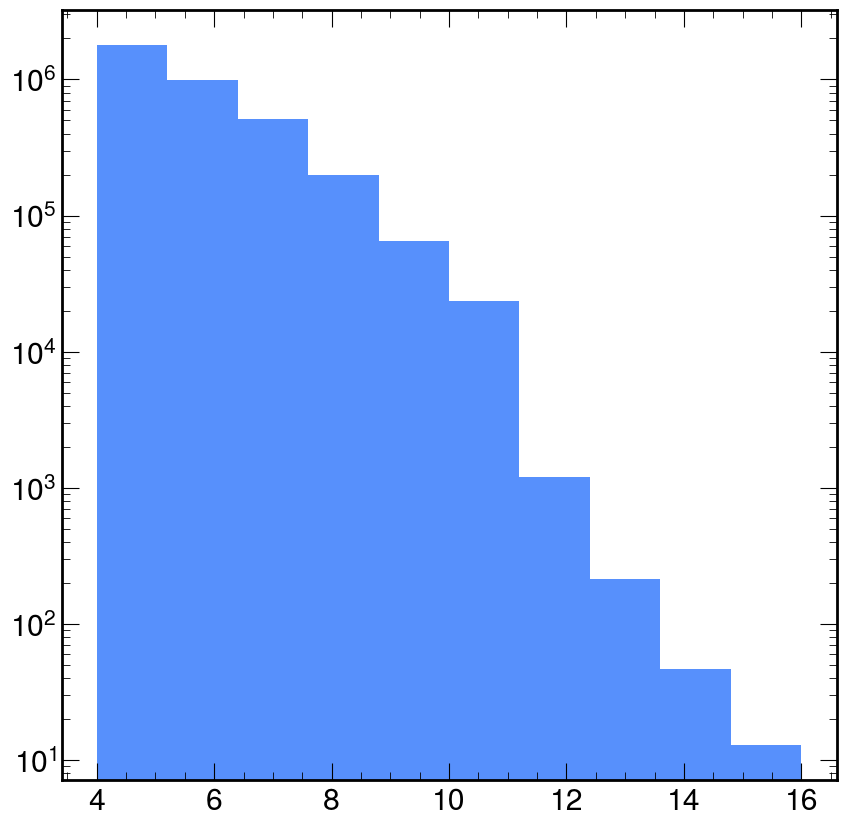

In [9]:
plt.hist(ak.num(jets))
plt.yscale("log")

In [10]:
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
sess_options = onnxruntime.SessionOptions()

sess_options.intra_op_num_threads = 20
sess_options.inter_op_num_threads = 2
#sess_options.intra_op_num_threads = 15
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL


session = onnxruntime.InferenceSession(
    f"{log_directory}/spanet_test1509.onnx", 
    sess_options = sess_options,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)

for input in session.get_inputs():
    print(f"{input.name}, {input.shape}")
    
for output in session.get_outputs():
    print(f"{output.name}, {output.shape}")

NameError: name 'log_directory' is not defined

In [140]:
jets_padded = ak.fill_none(ak.pad_none(jets, 16, clip=True), {"btag":0., "pt":0., "phi":0., "eta":0.})

data = np.transpose(
    np.stack([
    ak.to_numpy(jets_padded.btag),
    ak.to_numpy(jets_padded.eta),
    ak.to_numpy(jets_padded.phi),
    #ak.to_numpy(jets_padded.pt),
    np.log(1 + ak.to_numpy(jets_padded.pt))
    
    ]),
    axes=[1,2,0]).astype(np.float32)

mask = ~ak.to_numpy(jets_padded.pt == 0)

met_data = np.stack([ak.to_numpy(met.eta),
                     ak.to_numpy(met.phi),
                     #ak.to_numpy(met.pt)
                     np.log(1+ ak.to_numpy(met.pt))
                    ], axis=1)[:,None,:].astype(np.float32)

lep_data = np.stack([ak.to_numpy(lep[:,0].eta),
                     ak.to_numpy(lep[:,0].phi),
                     #ak.to_numpy(lep[:,0].pt)
                     np.log(1+ ak.to_numpy(lep[:,0].pt))
                ], axis=1)[:,None,:].astype(np.float32)

ht_array = np.sum(ak.to_numpy(jets_padded.pt), axis=1)[:,None, None].astype(np.float32)

mask_global = np.ones(shape=[met_data.shape[0], 1]) == 1

njets_good = ak.sum(mask, axis=1)

In [146]:
batch_size = 512
nbatches = data.shape[0]// batch_size
print(f"{nbatches=}")

nbatches=7000


In [156]:
from rich.progress import track

provenance = np.zeros((data.shape[0], 16))
prob_assignment = np.zeros((data.shape[0], 16, 3))


for i in track(range(nbatches), "Inference"):
#for i in range(nbatches):
    if i> 10: break
    #print(f"EVAL {i}")
    start = i*batch_size
    if i < (nbatches-1):
        stop = start+batch_size
    else:
        stop = len(data)
    outputs = session.run(input_feed={
        "Source_data": data[start:stop],
        "Source_mask": mask[start:stop],
        "Met_data": met_data[start:stop],
        "Met_mask": mask_global[start:stop],
        "Lepton_data": lep_data[start:stop],
        "Lepton_mask": mask_global[start:stop],
        "ht_data": ht_array[start:stop], 
        "ht_mask": mask_global[start:stop]},
        output_names=["t1_assignment_log_probability", "t2_assignment_log_probability",
                     "h_assignment_log_probability"]
        )
    #print(outputs)
    preds_nomask = spanet_predictions.extract_predictions(outputs[0:3], masking=False)
    prov, prob = assign_provenance_and_prob(*preds_nomask, outputs[0], outputs[1], outputs[2], 16)
    #print(prob)
    provenance[start:stop] = prov
    prob_assignment[start:stop]= prob

Output()

In [157]:
probabilities = np.exp(ak.to_numpy(prob_assignment))
# Factor two for symmetry reasons
probabilities[:,:,0] = probabilities[:,:,0] *2
probabilities[:,:,2] = probabilities[:,:,2] * 2

In [22]:
mask.sum(1)>=5

array([ True, False, False, ...,  True,  True,  True])

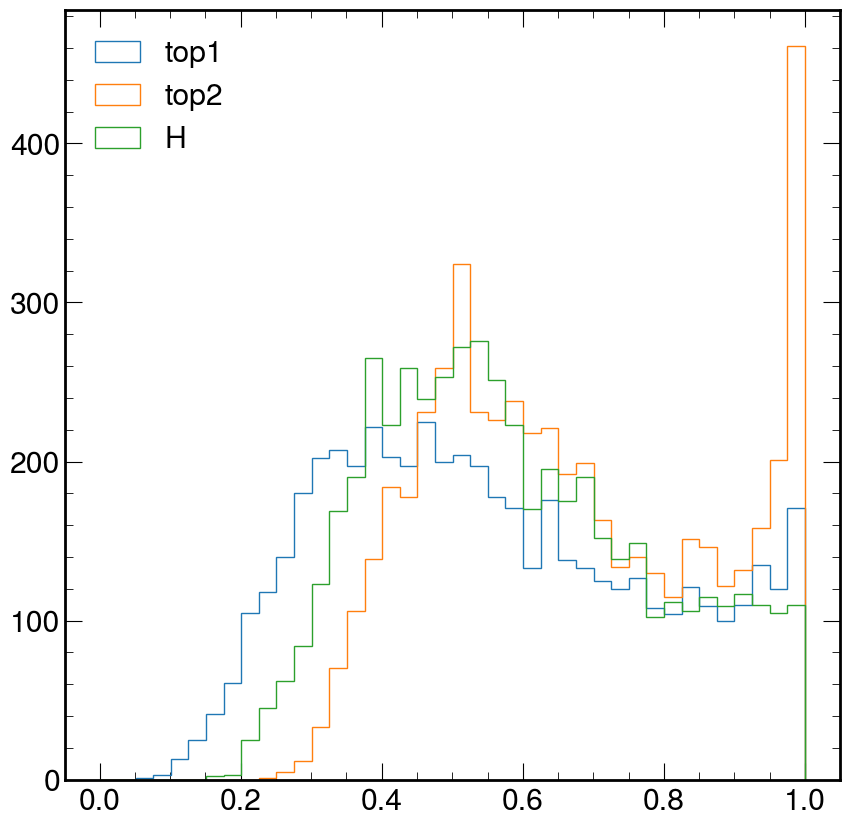

In [118]:
plt.hist(probabilities[:5120, :, 0].max(1).flatten(), bins=40, range=(0.001, 1),  histtype="step", label="top1")
plt.hist(probabilities[:5120, :, 1].max(1).flatten(), bins=40, range=(0.001, 1),  histtype="step", label="top2")
plt.hist(probabilities[:5120, :, 2].max(1).flatten(), bins=40, range=(0.001, 1),  histtype="step", label="H")
plt.legend()

### Comparison with Yuliia output

In [21]:
import h5py

In [23]:
f = h5py.File('ttHTobb_forTraining_2018_v0.h5', 'r')

In [24]:
f.keys()

<KeysViewHDF5 ['INPUTS', 'TARGETS']>

In [91]:
f["INPUTS"]["Source"]["eta"][100]

array([-0.21304321,  0.17739868,  0.75268555, -0.27062988,  0.9536133 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [141]:
data[100,:,1]

array([ 1.6271973 ,  0.9724121 , -0.01969147,  0.49468994,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [89]:
f["INPUTS"]["Source"]["pt"][100]

array([81.9375 , 70.6875 , 63.5    , 54.96875, 54.09375,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ], dtype=float32)

In [142]:
np.exp(data[100,:,-1])-1

array([82.5     , 71.062515, 70.68751 , 49.312508,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ], dtype=float32)

Ok the inputs are the same

In [71]:
h_b1 = f["TARGETS"]["h"]["b1"]
h_b2 = f["TARGETS"]["h"]["b2"]
prob_h = f["TARGETS"]["h"]["assignment_probability"]
t1_b = f["TARGETS"]["t1"]["b"]
t1_q1 = f["TARGETS"]["t1"]["q1"]
t1_q2 = f["TARGETS"]["t1"]["q2"]
prob_t1 = f["TARGETS"]["t1"]["assignment_probability"]
t2_b = f["TARGETS"]["t2"]["b"]
prob_t2 = f["TARGETS"]["t2"]["assignment_probability"]

In [104]:
probabilities[6]

array([[0.07415566, 0.        , 0.        ],
       [0.07415566, 0.        , 0.        ],
       [0.        , 0.47373339, 0.        ],
       [0.        , 0.        , 0.28772467],
       [0.        , 0.        , 0.28772467],
       [0.07415566, 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [84]:
for i in range(30):
    print(f"Ev:{i}, njets {njets_good[i]}.\n\tHiggs {h_b1[i]}, {h_b2[i]}, prob: {prob_h[i]:.3f}\
                                          \n\tTop had {t1_b[i]}, {t1_q1[i]}, {t1_q2[i]}, prob: {prob_t1[i]:.3f} \
                                          \n\tTop lep {t2_b[i]}, \tprob: {prob_t2[i]:.3f} ")

Ev:0, njets 5.
	Higgs 2, 4, prob: 0.635                                          
	Top had 0, 0, 0, prob: 0.000                                           
	Top lep 3, 	prob: 0.853 
Ev:1, njets 6.
	Higgs 0, 4, prob: 0.000                                          
	Top had 1, 2, 5, prob: 0.474                                           
	Top lep 3, 	prob: 0.483 
Ev:2, njets 6.
	Higgs 1, 3, prob: 0.986                                          
	Top had 0, 2, 5, prob: 0.959                                           
	Top lep 4, 	prob: 1.000 
Ev:3, njets 5.
	Higgs 2, 2, prob: 0.000                                          
	Top had 4, 1, 3, prob: 0.341                                           
	Top lep 0, 	prob: 0.726 
Ev:4, njets 7.
	Higgs 2, 4, prob: 0.607                                          
	Top had 3, 0, 1, prob: 0.608                                           
	Top lep 5, 	prob: 0.189 
Ev:5, njets 6.
	Higgs 1, 4, prob: 0.586                                          
	Top had 5, 0

In [67]:
prob_h5[0:10]

array([6.3540822e-01, 3.6050123e-04, 9.8603487e-01, 0.0000000e+00,
       6.0693693e-01, 5.8563584e-01, 8.0790257e-01, 0.0000000e+00,
       4.2867675e-01, 0.0000000e+00], dtype=float32)

It was a missing factor two for symmetries!!

In [69]:
njets_good[0:10]

<Array [5, 6, 6, 5, 7, 6, 8, 5, 6, 4] type='10 * int64'>

(array([453821.,  23034.,  15262.,  11990.,  10427.,   8965.,   8194.,
          7541.,   7022.,   6528.,   6460.,   6133.,   6056.,   6068.,
          6026.,   6046.,   6004.,   6243.,   6406.,   6479.,   6578.,
          6955.,   7302.,   7245.,   7662.,   8039.,   8242.,   8694.,
          8799.,   9024.,   9526.,   9964.,  10179.,  10606.,  10712.,
         10988.,  11104.,  11522.,  11729.,  11652.,  12046.,  11996.,
         12189.,  12265.,  12176.,  12358.,  12404.,  12460.,  12366.,
         12210.,  12311.,  11870.,  11856.,  11521.,  11397.,  11340.,
         10818.,  10627.,  10485.,  10344.,  10001.,   9958.,   9677.,
          9549.,   9182.,   8979.,   8934.,   8798.,   8746.,   8554.,
          8306.,   8308.,   8100.,   8015.,   7804.,   7812.,   7658.,
          7415.,   7450.,   7435.,   7234.,   7205.,   7086.,   7074.,
          6953.,   6878.,   6868.,   6894.,   6657.,   6840.,   6733.,
          6756.,   6610.,   6706.,   6707.,   6952.,   6915.,   7067.,
      

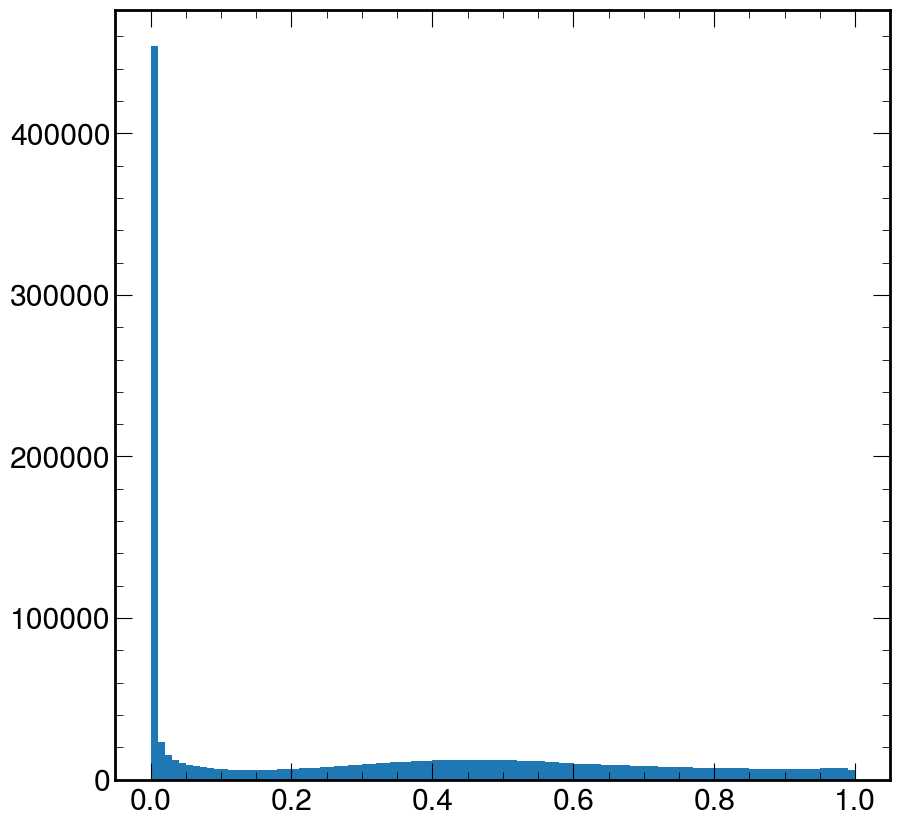

In [62]:
plt.hist(f["TARGETS"]["h"]["assignment_probability"],bins=100, range=(0,1))

## Analysis of fully matched events

In [119]:
mask_fully_matched = (ak.sum((jets.prov==1), axis=1) ==1 )&(ak.sum((jets.prov==2), axis=1) ==1 )&(ak.sum((jets.prov==3), axis=1) ==1 )&(ak.sum((jets.prov==5), axis=1) ==2 )

In [121]:
ak.sum(mask_fully_matched) / len(jets)

0.10592620805703633

In [122]:
probabilities.shape

(3584250, 16, 3)

In [123]:
plt.hist(probabilities[mask_fully_matched][:, :,0].max(1).flatten(), bins=40, range=(0.001, 1),  histtype="step", label="top1")
plt.hist(probabilities[mask_fully_matched][:, :, 1].max(1).flatten(), bins=40, range=(0.001, 1),  histtype="step", label="top2")
plt.hist(probabilities[mask_fully_matched][:, :, 2].max(1).flatten(), bins=40, range=(0.001, 1),  histtype="step", label="H")
plt.legend()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3584250 but corresponding boolean dimension is 1344266

(array([4.76875e+05, 0.00000e+00, 8.00000e+00, 9.80000e+01, 4.63000e+02,
        1.31000e+03, 3.05900e+03, 5.65100e+03, 9.01400e+03, 1.32970e+04,
        1.84120e+04, 2.36170e+04, 2.92800e+04, 3.54100e+04, 4.19810e+04,
        4.74550e+04, 5.36870e+04, 5.93060e+04, 6.37210e+04, 6.70700e+04,
        7.07230e+04, 7.40230e+04, 7.65910e+04, 8.02960e+04, 8.35450e+04,
        8.38670e+04, 8.11200e+04, 7.81650e+04, 7.58360e+04, 7.27340e+04,
        7.05710e+04, 6.86840e+04, 6.63050e+04, 6.58760e+04, 6.42460e+04,
        6.32850e+04, 6.32780e+04, 6.21570e+04, 6.15070e+04, 6.13860e+04,
        6.09110e+04, 6.02810e+04, 6.03360e+04, 6.11200e+04, 6.11760e+04,
        6.23280e+04, 6.38120e+04, 6.70930e+04, 7.40120e+04, 8.55770e+04,
        1.77780e+04, 1.72620e+04, 1.67490e+04, 1.61240e+04, 1.54290e+04,
        1.51390e+04, 1.42820e+04, 1.39800e+04, 1.33860e+04, 1.30620e+04,
        1.27440e+04, 1.20910e+04, 1.17700e+04, 1.13470e+04, 1.08880e+04,
        1.05530e+04, 1.02380e+04, 1.00110e+04, 9.59

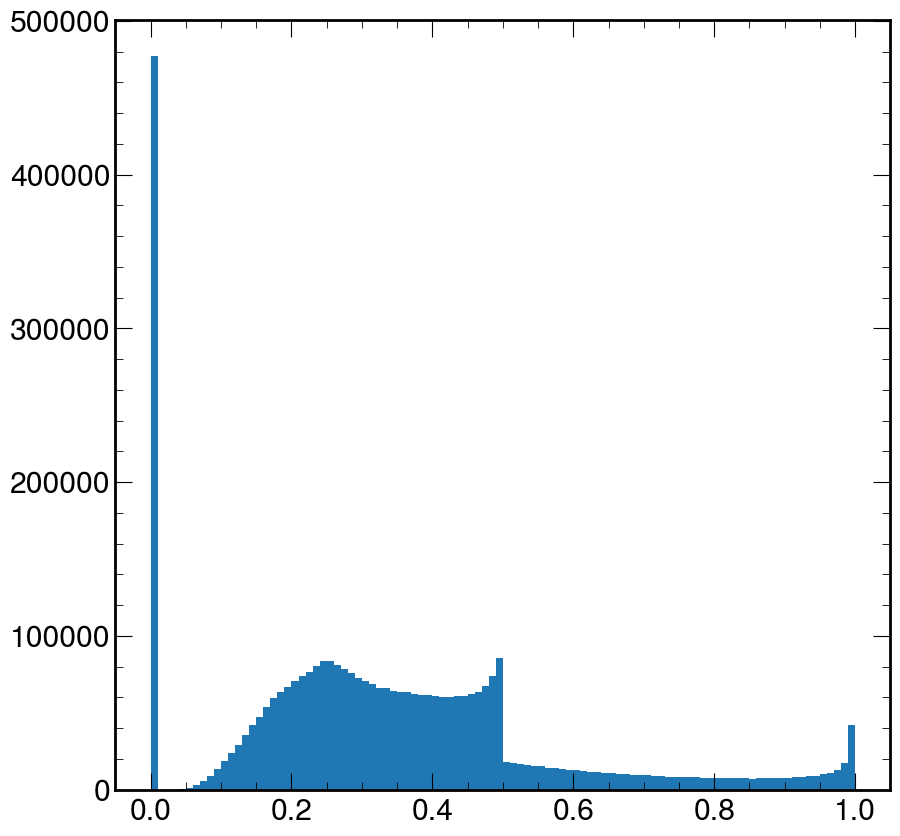

In [69]:
plt.hist(probabilities[:,2].max(1), bins=100)

## Removing the padding

In [158]:
prob_assignment_saved = ak.from_parquet(basedir + "/../spanet.parquet")["spanet_prob_assignment"]
prob_assignment_saved = ak.to_numpy(prob_assignment_saved)

prob_assignment = np.exp(prob_assignment_saved)
# Factor two for symmetry reasons
prob_assignment[:,:,0] = prob_assignment[:,:,0] *2
prob_assignment[:,:,2] = prob_assignment[:,:,2] * 2

In [162]:
probabilities[100]

array([[0.        , 0.        , 0.77142059],
       [0.57647595, 0.        , 0.        ],
       [0.57647595, 0.34694307, 0.        ],
       [0.57647595, 0.        , 0.77142059],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [163]:
prob_assignment[100]

array([[0.        , 0.        , 0.77142059],
       [0.57647595, 0.        , 0.        ],
       [0.57647595, 0.34694307, 0.        ],
       [0.57647595, 0.        , 0.77142059],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [164]:
ak.to_parquet(ak.zip({"spanet_prob_assignment": ak.from_numpy(prob_assignment)}), basedir + "/../spanet.parquet" )

  created_by: parquet-cpp-arrow version 13.0.0
  num_columns: 1
  num_rows: 3584250
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [165]:
njets_good = ak.sum(mask, axis=1)

In [166]:
prob_assign_reshape = np.reshape(prob_assignment, (-1, 3) )
prob_masked = prob_assign_reshape[mask.flatten()]
prob_ak = ak.unflatten(ak.from_numpy(prob_masked), njets_good)

In [167]:
prob_ak

<Array [[[0, 0.664, 0], ..., [0, ...]], ...] type='3584250 * var * 3 * float64'>

In [168]:
df["prob_ak"] = prob_ak
df["jets"] = ak.zip( dict(zip(df.jets.fields,ak.unzip(df.jets))) |  {"prov_Thad": prob_ak[:,:,0],"prov_Tlep": prob_ak[:,:,1],"prov_H": prob_ak[:,:,2]})

In [169]:
df.jets.prov_Thad

<Array [[0, 0.888, 0.888, 0.888, 0], ..., [...]] type='3584250 * var * float64'>

In [170]:
ak.to_parquet(df, basedir + "/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov.parquet")

  created_by: parquet-cpp-arrow version 13.0.0
  num_columns: 45
  num_rows: 3584250
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [172]:
prob_ak[:,:,0]

<Array [[0, 0.888, 0.888, 0.888, 0], ..., [...]] type='3584250 * var * float64'>

<Array [True, True, True, ... True, True, True] type='3584250 * bool'>

In [171]:
df.jets[(njets_good >= 6)].prov_H

<Array [[0, 0, 0, 0.669, 0.669, 0], ..., [...]] type='1784384 * var * float64'>

(array([1.546251e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        6.000000e+00, 1.210000e+02, 8.260000e+02, 3.208000e+03,
        9.353000e+03, 2.029800e+04, 3.730700e+04, 5.854900e+04,
        8.323300e+04, 1.080110e+05, 1.319110e+05, 1.513600e+05,
        1.678330e+05, 1.824600e+05, 1.960330e+05, 2.087450e+05,
        2.074730e+05, 1.949540e+05, 1.837210e+05, 1.720980e+05,
        1.631260e+05, 1.528020e+05, 1.448160e+05, 1.375710e+05,
        1.307850e+05, 1.260380e+05, 1.213270e+05, 1.164110e+05,
        1.127750e+05, 1.104510e+05, 1.078180e+05, 1.073770e+05,
        1.073590e+05, 1.090250e+05, 1.154450e+05, 1.245740e+05]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 a

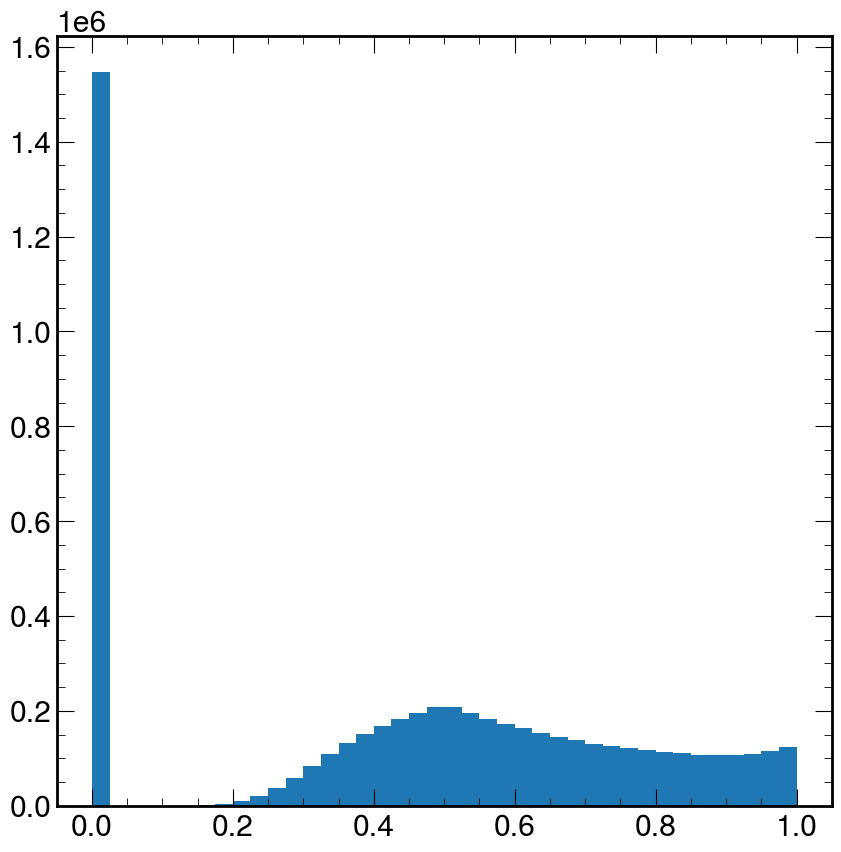

In [176]:
plt.hist(ak.flatten(df.jets[df.jets.prov==1].prov_H), bins=40, range=(0,1))

(array([1.3111985e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.4000000e+01, 4.4400000e+02, 2.6780000e+03, 9.6120000e+03,
        2.6214000e+04, 5.3458000e+04, 9.3174000e+04, 1.4006400e+05,
        1.9149000e+05, 2.4046600e+05, 2.8230600e+05, 3.1573000e+05,
        3.4060200e+05, 3.6126200e+05, 3.7803400e+05, 3.9259000e+05,
        3.8030600e+05, 3.5240800e+05, 3.2689600e+05, 3.0170400e+05,
        2.8130200e+05, 2.6050400e+05, 2.4276000e+05, 2.2698800e+05,
        2.1169400e+05, 2.0014800e+05, 1.8917400e+05, 1.7701800e+05,
        1.6758600e+05, 1.6055200e+05, 1.5242200e+05, 1.4688800e+05,
        1.4171000e+05, 1.3813400e+05, 1.3952600e+05, 1.4262200e+05]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975

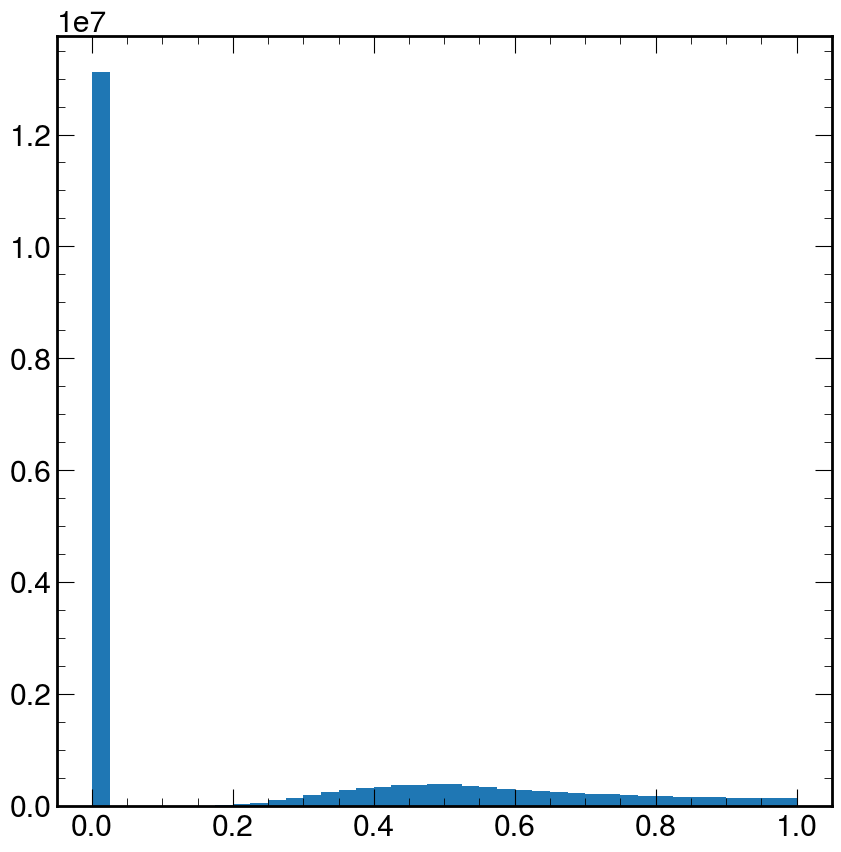

In [173]:
plt.hist(ak.flatten(df.jets.prov_H), bins=40, range=(0,1))

(array([9.0189e+05, 3.0000e+00, 7.8000e+01, 6.5000e+02, 2.7210e+03,
        7.1340e+03, 1.4481e+04, 2.3733e+04, 3.3990e+04, 4.4253e+04,
        5.3856e+04, 6.1846e+04, 6.8084e+04, 7.3658e+04, 7.6593e+04,
        7.8191e+04, 7.9870e+04, 7.9699e+04, 8.0602e+04, 8.2467e+04,
        8.0757e+04, 7.6304e+04, 7.2172e+04, 6.8407e+04, 6.5100e+04,
        6.2020e+04, 5.9703e+04, 5.7174e+04, 5.5444e+04, 5.3355e+04,
        5.2235e+04, 5.1278e+04, 4.9547e+04, 4.9307e+04, 4.9560e+04,
        5.0199e+04, 5.2067e+04, 5.5967e+04, 6.5861e+04, 9.3668e+04]),
 array([0.        , 0.02499778, 0.04999557, 0.07499335, 0.09999113,
        0.12498891, 0.1499867 , 0.17498448, 0.19998226, 0.22498004,
        0.24997783, 0.27497561, 0.29997339, 0.32497118, 0.34996896,
        0.37496674, 0.39996452, 0.42496231, 0.44996009, 0.47495787,
        0.49995566, 0.52495344, 0.54995122, 0.574949  , 0.59994679,
        0.62494457, 0.64994235, 0.67494013, 0.69993792, 0.7249357 ,
        0.74993348, 0.77493127, 0.79992905, 0.

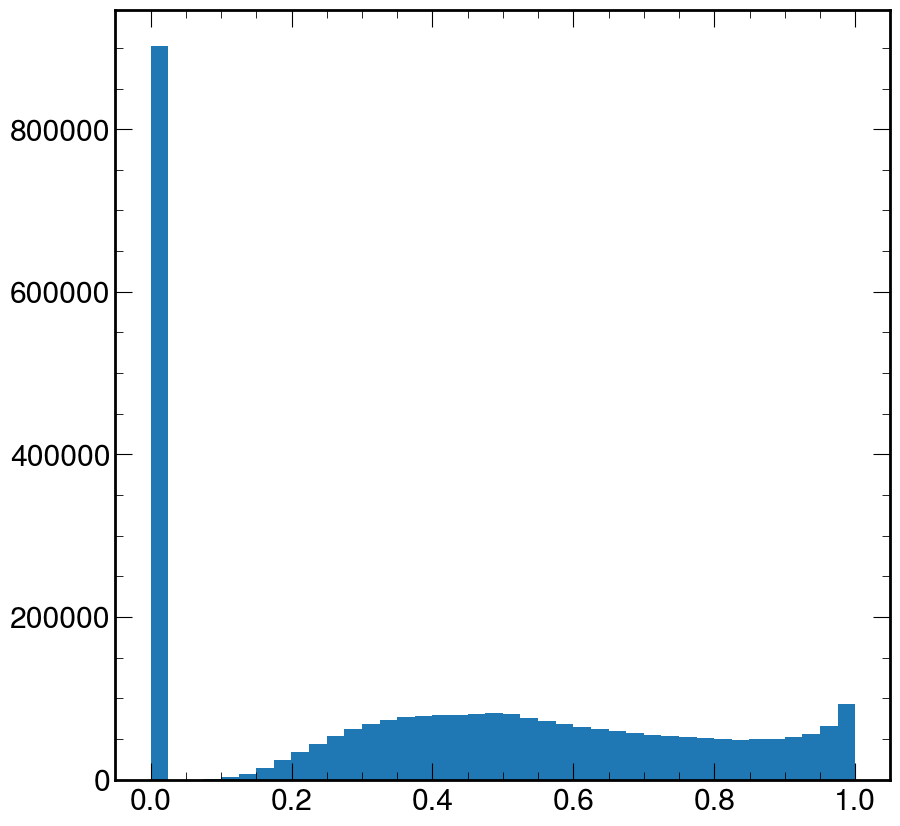

In [174]:
plt.hist(ak.flatten(df.jets[df.jets.prov==2].prov_Thad), bins=40)

(array([1.6696235e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.0000000e+00,
        7.3000000e+01, 5.5400000e+02, 2.8940000e+03, 1.0056000e+04,
        2.2428000e+04, 4.5967000e+04, 7.7955000e+04, 1.0391200e+05,
        1.2470800e+05, 1.4067600e+05, 1.5593600e+05, 1.7763600e+05,
        2.0003100e+05, 1.8590100e+05, 1.7232900e+05, 1.5908800e+05,
        1.4757500e+05, 1.3757800e+05, 1.2864100e+05, 1.1992100e+05,
        1.1355500e+05, 1.0669600e+05, 1.0229500e+05, 9.8007000e+04,
        9.4966000e+04, 9.3555000e+04, 9.3163000e+04, 9.5302000e+04,
        1.0002700e+05, 1.1189100e+05, 1.3816600e+05, 3.2275900e+05]),
 array([0.        , 0.02499999, 0.04999998, 0.07499996, 0.09999995,
        0.12499994, 0.14999993, 0.17499992, 0.1999999 , 0.22499989,
        0.24999988, 0.27499987, 0.29999986, 0.32499985, 0.34999983,
        0.37499982, 0.39999981, 0.4249998 , 0.44999979, 0.47499977,
        0.49999976, 0.52499975, 0.54999974, 0.

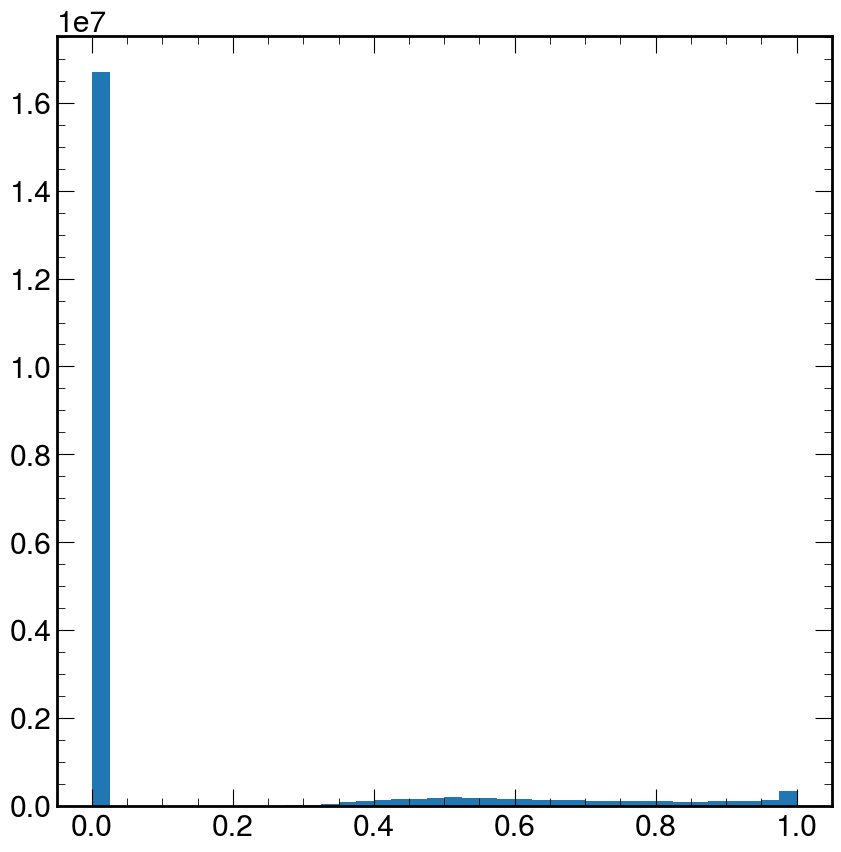

In [175]:
plt.hist(ak.flatten(df.jets.prov_Tlep), bins=40)

In [ ]:
ak.__version__